# LangChain Expression Language (LCEL)

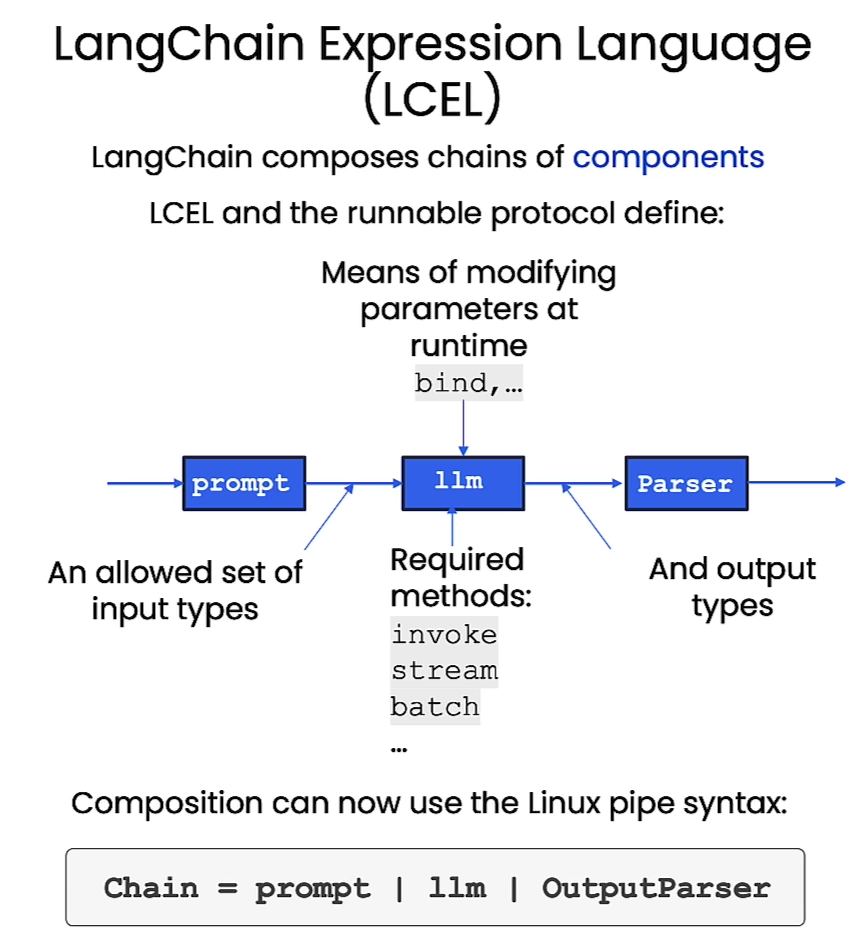

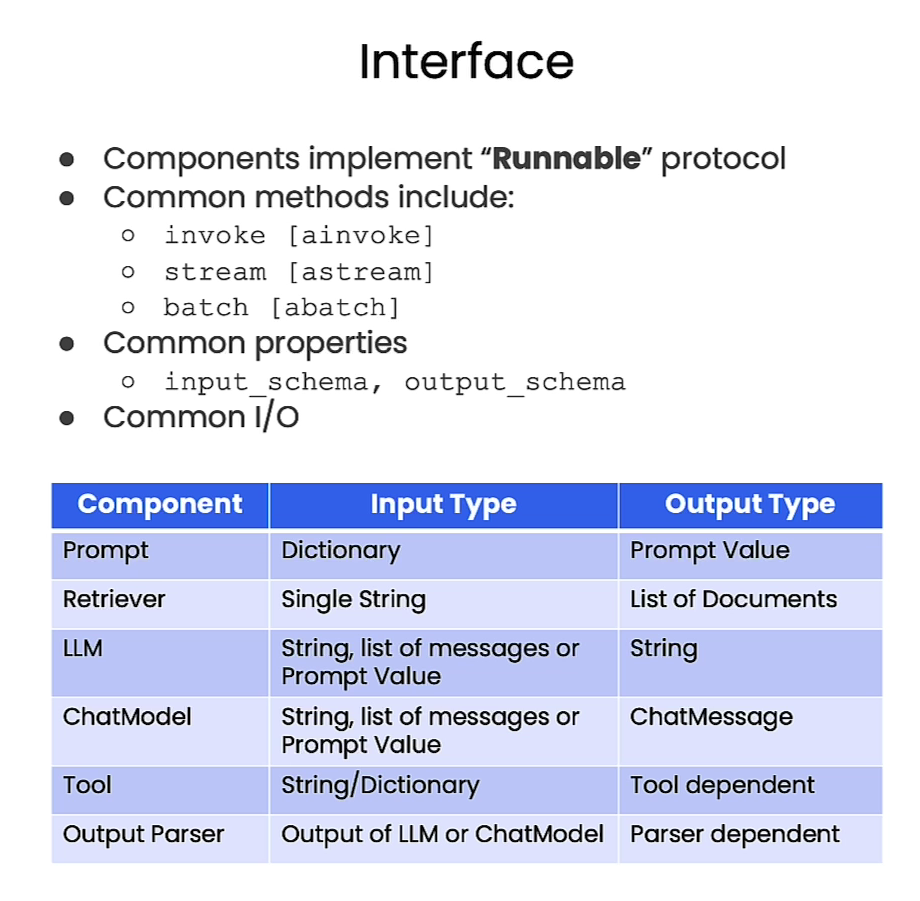

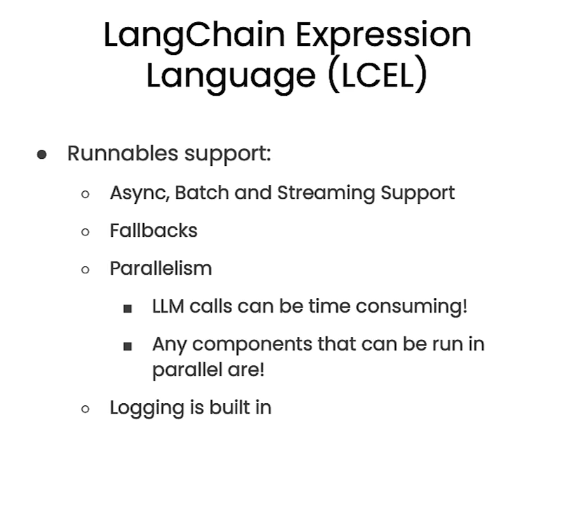

In [ ]:
#!pip install pydantic==1.10.8

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

## Simple Chain

In [2]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser() # Convert ChatMessage to str

In [3]:
chain = prompt | model | output_parser

In [4]:
chain.invoke({"topic": "honey"})

'Why did the bee get married? Because he found his honey!'

## More complex chain

And Runnable Map to supply user-provided inputs to the prompt.

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch

In [6]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["Fu Lim study at TARUMT", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [7]:
retriever.invoke("where did Fu Lim study?")

[Document(page_content='Fu Lim study at TARUMT'),
 Document(page_content='bears like to eat honey')]

In [8]:
retriever.invoke("what do bears like to eat")

[Document(page_content='bears like to eat honey'),
 Document(page_content='Fu Lim study at TARUMT')]

In [9]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [10]:
from langchain.schema.runnable import RunnableMap

In [11]:
chain = RunnableMap({
    "context": lambda x: retriever.invoke(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [12]:
chain.invoke({"question": "where did Fu Lim study?"})

'Fu Lim studied at TARUMT.'

In [13]:
inputs = RunnableMap({
    "context": lambda x: retriever.invoke(x["question"]),
    "question": lambda x: x["question"]
})

In [14]:
inputs.invoke({"question": "where did Fu Lim study?"})

{'context': [Document(page_content='Fu Lim study at TARUMT'),
  Document(page_content='bears like to eat honey')],
 'question': 'where did Fu Lim study?'}

## Bind

and OpenAI Functions

In [15]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [16]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [17]:
runnable = prompt | model

In [18]:
runnable.invoke({"input": "what is the weather in sf"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'weather_search'}}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 64, 'total_tokens': 80}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-44c78595-9c38-4e9a-95f3-530caa8da592-0', usage_metadata={'input_tokens': 64, 'output_tokens': 16, 'total_tokens': 80})

In [19]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [20]:
model = model.bind(functions=functions)

In [21]:
runnable = prompt | model

In [23]:
runnable.invoke({"input": "how did the golden state warriors do yesterday?"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"team_name":"golden state warriors"}', 'name': 'sports_search'}}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 100, 'total_tokens': 118}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-bde8ed6d-2be3-4736-906f-51af51dfd896-0', usage_metadata={'input_tokens': 100, 'output_tokens': 18, 'total_tokens': 118})

## Fallbacks

In [38]:
from langchain_openai import OpenAI # Can support older version of OpenAI API (gpt-3.5-turbo-instruct)
# ChatModel only accept gpt-3.5-turbo,not gpt-3.5-turbo-instruct
import json

In [39]:
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="gpt-3.5-turbo-instruct"
)
simple_chain = simple_model | json.loads

In [40]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [41]:
simple_model.invoke(challenge)

'\n\n{\n    "title": "Autumn Leaves",\n    "author": "Emily Dickinson",\n    "first_line": "The leaves are falling, one by one"\n}\n\n{\n    "title": "The Ocean\'s Song",\n    "author": "Pablo Neruda",\n    "first_line": "I hear the ocean\'s song, a symphony of waves"\n}\n\n{\n    "title": "A Winter\'s Night",\n    "author": "Robert Frost",\n    "first_line": "The snow falls softly, covering the ground"\n}'

**Note**: The next line is expected to fail.

In [42]:
simple_chain.invoke(challenge)

JSONDecodeError: Extra data: line 9 column 1 (char 125)

In [43]:
model = ChatOpenAI(temperature=0) # New type of ChatModel perform better at challenges , can use as a fallback
chain = model | StrOutputParser() | json.loads

In [44]:
chain.invoke(challenge)

{'poem1': {'title': 'The Rose',
  'author': 'Emily Dickinson',
  'firstLine': 'A rose by any other name would smell as sweet'},
 'poem2': {'title': 'The Road Not Taken',
  'author': 'Robert Frost',
  'firstLine': 'Two roads diverged in a yellow wood'},
 'poem3': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'firstLine': 'Hope is the thing with feathers that perches in the soul'}}

In [45]:
final_chain = simple_chain.with_fallbacks([chain])

In [46]:
final_chain.invoke(challenge)

{'poem1': {'title': 'The Night Sky',
  'author': 'Emily Dickinson',
  'firstLine': 'The night is starry and the stars are blue.'},
 'poem2': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'firstLine': 'Hope is the thing with feathers'},
 'poem3': {'title': 'The Road Not Taken',
  'author': 'Robert Frost',
  'firstLine': 'Two roads diverged in a yellow wood,'}}

## Interface

In [48]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [49]:
chain.invoke({"topic": "bears"}) # synchronous method that calls on single input

"Why don't bears wear shoes?\n\nBecause they have bear feet!"

In [50]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}]) # call the chain on a list of inputs

["Why don't bears like fast food?\n\nBecause they can never catch up!",
 'Why are frogs so happy? Because they eat whatever bugs them!']

In [51]:
for t in chain.stream({"topic": "bears"}): # chain.stream is a generator that yields results as they come in (return iterator)
    print(t)


Why
 did
 the
 bear
 bring
 a
 flashlight
 to
 the
 party
?
 


Because
 he
 wanted
 to
 be
 the
 light
 of
 the
 bear
-b
ec
ue
!



In [55]:
response = await chain.ainvoke({"topic": "bears"})
response

'Why did the bear bring a flashlight to the party? \n\nBecause he heard it was going to be a "bear"y dark night!'